In [1]:
from pathlib import Path

DATA = Path("scrape")
assert DATA.is_dir()

In [2]:
from ipyfilechooser import FileChooser
from ipywidgets import Layout

fc = FileChooser(
    DATA,
    filter_pattern="*.pdf",
    title="Select PDF file to extract",
    layout=Layout(width="100%"),
)
display(fc)

FileChooser(path='/home/max/Documents/Code/BDRAD/Radiology Books/scrape', filename='', title='Select PDF file …

In [3]:
fname = Path(fc.selected)
assert fname.is_file()
print(f"File selected: [{fname.name}]({fname.as_uri()})")

File selected: [Chest - Elicker - HRCT of the Lungs 2e.pdf](file:///home/max/Documents/Code/BDRAD/Radiology%20Books/scrape/Chest%20-%20Elicker%20-%20HRCT%20of%20the%20Lungs%202e.pdf)


In [4]:
import fitz

pdf: fitz.Document = fitz.open(fname)

In [5]:
class Config:
    # todo typeing for font_* sets
    odd_spread = True  # inner corresponds to right-side of odd pages, left-side of even pages
    crop_top: int = 0
    crop_inner: int = 0
    crop_bot: int = 0
    crop_outer: int = 0
    font_header: set = None
    font_body: set = None
    font_ignore: set = None
    font_ignore_names: set = None
    chapters: list = None

    def __init__(self, fname: Path):
        match fname.name:
            case "Chest - Elicker - HRCT of the Lungs 2e.pdf":
                self.crop_top = 65
                self.crop_inner = 40
                self.crop_bot = 30
                self.crop_outer = 40
                self.font_header = set()    # todo
                self.font_body = set()  # todo
                self.font_ignore = set()    # todo
                self.font_ignore_names = set()  # todo
                self.chapters = [49, 62, 83, 104, 116, 129, 150, 166, 174, 199, 212, 221, 233, 247, 265, 274, 283, 296, 305]
                

            case "Chest - Felson - Principles of Chest Roentgenology (4e).pdf":
                # TODO figure out how to consistently extract QA pairs
                self.crop_top = 50
                self.crop_inner = 40
                self.crop_bot = 50
                self.crop_outer = 50

            case "Chest - Webb - Fundamentals of Body CT (4e).pdf":
                self.crop_top = 60
                self.crop_inner = 40
                self.crop_bot = 30
                self.crop_outer = 30
                self.font_header = {(13.0, 'Univers-CondensedBold'), (10.0, 'Univers-BoldOblique')}
                self.font_body = {
                    (10.0, "JansonText-Roman"),
                    (10.0, "JansonText-Italic"),
                    (10.0, 'JansonText-Bold'),
                    (10.0, 'JansonText-BoldItalic'),
                    (10.0, 'TnQ'), # greek characters
                }
                self.font_ignore = {
                    (16.0, "JansonText-Roman"),  # chapter title font
                    (7.199999809265137, "JansonText-Roman-SC800"),
                    (9.0, "JansonText-Roman-SC800"),
                    (27.0, "JansonText-Roman-SC800"),
                    (21.600000381469727, "JansonText-Roman-SC800"),
                    (8.0, 'Univers-CondensedBold'), # figure labels
                    (8.0, 'Univers-BoldOblique'), # figure labels
                    (10.0, 'Univers-CondensedBold'), # page numbers
                }
                self.font_ignore_names = {'Helvetica',   # figures
                                          'Helvetica-Bold',
                                          'ZapfDingbats', # bullet points
                                          'Univers', # table body
                                          'Univers-Light', # table footer
                                          'Univers-Oblique', # figure arrows
                                          'Univers-Bold', # table header
                                          'Univers-Condensed', # table label
                                        #   'Sabon-Roman'
                }
                # Chapters are zero-indexed, and final number is the last page of the final chapter
                self.chapters = [6,12,26,49,73,94,134,151,176,188,214,225,241,250,278,290,323,340,349,363,370,]
            case "General - Mandell - Core Radiology (1e).pdf":
                self.crop_top = 10
                self.crop_inner = 30
                self.crop_bot = 30
                self.crop_outer = 30
                self.font_header = {(11.0, 'TwCenMT-CondensedExtraBo'),
                                    (18.0, 'Calibri-Bold'),
                                    (14.0, 'Calibri-Bold'),}    
                self.font_body = {(12.0, 'Calibri'),(10.0, 'Calibri'),(10.0, 'Calibri-Bold')}
                self.font_ignore_names = {'ArialMT','MyriadPro-Regular','MyriadPro-It','Wingdings2'}
                self.font_ignore = {(-1, ''),} 
                self.chapters = [669,702]
            case _:
                raise KeyError
            
        
        overlapping_fonts = self.font_ignore_names.intersection([x[1] for x in self.font_body.union(self.font_header)])
        assert not overlapping_fonts, f"These fonts are both ignored and included: {overlapping_fonts}"

    def chapter_range(self):
        return list(zip(self.chapters, self.chapters[1:]))

    def contained_chapter(self, page: fitz.Page, chapter_range=None):
        chapter_range = chapter_range or self.chapter_range()
        for i, (start, end) in enumerate(chapter_range):
            if (start or float("-inf")) <= page.number < (end or float("inf")):
                return i
        return None

    def get_cropbox(self, pg: fitz.Page):
        inr, outr = self.crop_inner, self.crop_outer
        if ((pg.number + 1) % 2) and config.odd_spread:
            inr, outr = outr, inr

        return (
            outr,
            config.crop_top,
            pg.rect.width - inr,
            pg.rect.height - config.crop_bot,
        )

    def crop_page(self, pg: fitz.Page):
        if pg.cropbox_position == fitz.Point():  # botched to check if cropbox is not set
            crop_box = self.get_cropbox(pg)
            pg.set_cropbox(crop_box)


config = Config(fname)

# config.chapter_range()

In [6]:
# pages = pdf[config['pg_start']:]
start, end = config.chapter_range()[0]
# pages = pdf[start:end]

pdf.select(range(start, end))

print(len(pdf))

13


In [7]:
pg: fitz.Page = pdf[3]

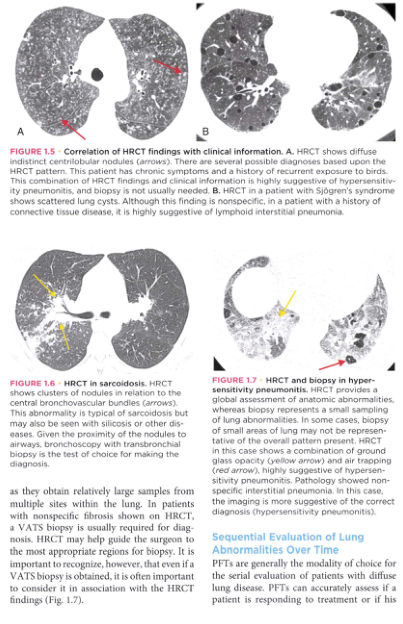

In [8]:
from PIL import Image
from io import BytesIO


def page_to_img(pg: fitz.Page, config=config):
    im: fitz.Pixmap = pg.get_pixmap(clip=config.get_cropbox(pg))
    bytes = im.tobytes("png")
    return Image.open(BytesIO(bytes))


# crop_page(pg)
page_to_img(pg)

# processing

In [23]:
import re

In [22]:
import nltk
# nltk.download('wordnet31')

from nltk.corpus import wordnet31 as wordnet

hyphen_corpus = set(filter(lambda w: "-" in w, wordnet.words()))

In [35]:
# TODO: words such as high-XXX, minimum-XXX, etc. should not be de-hyphenated
# Need to get such prefix words (prefix corpus)
# Need to evaluate the prefix (that before '-') and determine if it is in this prefix corpus

False

In [29]:
def dehyphenate_string(input_string):
    out = ""

    input_string = re.sub(r"\s*-\s*", r"-", input_string)   # remove surronding spaces; join hyphenated words

    for word in input_string.split():
        if "-" not in word: 
            out += word + " "
            continue

        match = re.search(r'^(\W*)([\w-]*)(\W*)$', word)
        pre, word, post = match.groups()
        if word not in hyphen_corpus:
            print('Dehyphenating word: ', word)
            word = word.replace("-", "")
        out += pre + word + post + " "
    return out


input_string = "This is an ex-ampl-e of a de-hyphenated string. x-ray is a hyphenated word."
output_string = dehyphenate_string(input_string)
print(output_string)

Dehyphenating word:  ex-ampl-e
Dehyphenating word:  de-hyphenated
This is an example of a dehyphenated string. x-ray is a hyphenated word. 


In [32]:
def process_text(text: str) -> str:
    
    sentences = re.split(r'(?<=[.?!;\n])', text)    # this will split, but preserve the delimiter
    out = ""
    for sent in sentences:
        low = sent.lower()

        ref_parenthesis = r"\(.*(table|fig(\.|ure)) \d.+?\)"    # e.x. (lorem Table 1 ipsum) or (Fig. 2.1)
        low = re.sub(ref_parenthesis, "", low)

        ref_whole = r"(table|fig(\.|ure)) \d"
        if re.search(ref_whole, low):
            continue

        low = dehyphenate_string(low)

        out += low
    
    return out

test_txt = """Because scan data are acquired continuously and volumetrically using spiral CT, scans may be reconstructed in any plane desired, if appropriate workstations are available. A variety of display techniques have been used for imaging the tho-rax. These include multiplanar reconstructions, three-dimensional shaded surface display or vol-ume rendering from an external perspective, or shaded surface or volume rendering from an internal (i.e., endoluminal) perspective, also known as virtual bronchoscopy.
Multiplanar, two-dimensional reconstructions offer the advantage of being quickly performed and are sufficient for diagnosis in most cases in which a reformation is considered desirable. Subsequent chapters provide a number of examples of two-dimensional reconstructions. Three-dimensional techniques, such as shaded surface display and vol-ume rendering, can be valuable in selected cases, but they are time-consuming and require consider-able operator experience. These techniques are not commonly used in clinical chest imaging, with the exception of virtual bronchoscopy or airway imag-ing and specialized vascular imaging.
Maximum- or minimum-intensity projection images representing a slab of three-dimensional data reconstructed from a volumetric data set may sometimes be useful in imaging pulmonary, airway, or vascular abnormalities."""
process_text(test_txt)

Dehyphenating word:  tho-rax
Dehyphenating word:  vol-ume
Dehyphenating word:  vol-ume
Dehyphenating word:  consider-able
Dehyphenating word:  imag-ing
Dehyphenating word:  maximum-or
Dehyphenating word:  minimum-intensity


'because scan data are acquired continuously and volumetrically using spiral ct, scans may be reconstructed in any plane desired, if appropriate workstations are available. a variety of display techniques have been used for imaging the thorax. these include multiplanar reconstructions, three-dimensional shaded surface display or volume rendering from an external perspective, or shaded surface or volume rendering from an internal (i. e. , endoluminal) perspective, also known as virtual bronchoscopy. multiplanar, two-dimensional reconstructions offer the advantage of being quickly performed and are sufficient for diagnosis in most cases in which a reformation is considered desirable. subsequent chapters provide a number of examples of two-dimensional reconstructions. three-dimensional techniques, such as shaded surface display and volume rendering, can be valuable in selected cases, but they are time-consuming and require considerable operator experience. these techniques are not commonl

In [35]:
def process_page(pg: fitz.Page):
    # page_to_img(pg).show()

    continuation = ""  # base text continuing from previous page's last entry
    mode = "startup"  # startup, header, body
    entries = []  # list of (header, text) tuples
    current_entry = ["", ""]  # current entry (header, text)
    done = False # whether we've reached the end of the chapter (e.x. sugguested readings section)

    flags = fitz.TEXTFLAGS_DICT & ~fitz.TEXT_PRESERVE_IMAGES & fitz.TEXT_DEHYPHENATE

    tessdata=Path('/usr/share/tessdata')
    tp = pg.get_textpage(flags=flags)   # default behavior
    # tp = pg.get_textpage_ocr(flags=flags, full=True, dpi=300, tessdata=tessdata)   # full
    # tp = pg.get_textpage_ocr(flags=flags, full=False, tessdata=tessdata)   # partial

    dict = pg.get_text("dict", textpage=tp, flags=flags, clip=config.get_cropbox(pg))
    blocks = dict["blocks"]
    for block in blocks:
        for line in block["lines"]:
            for span in line["spans"]:
                txt = span["text"]

                if txt == 'SUGGESTED READING':
                    print('### Found end of chapter, stopping early ### ')
                    done = True
                    if mode == "body":
                        entries.append([ent.strip() for ent in current_entry])
                    return entries, continuation.strip(), done

                # if txt.endswith("-") and abs(w["x1"] - x1) < 0.08 * pg.width:

                font = (span["size"], span["font"])
                # print(font, txt)
                if font in config.font_ignore or span["font"] in config.font_ignore_names:
                    continue
                elif font in config.font_header:
                    match mode:
                        case "startup":
                            mode = "header"
                            current_entry = [txt, ""]
                        case "header":
                            current_entry[0] += txt
                        case "body":
                            mode = "header"
                            entries.append([ent.strip() for ent in current_entry])
                            current_entry = [txt, ""]
                elif font in config.font_body:
                    match mode:
                        case "startup":
                            if txt.endswith("."):
                                txt += "\n"
                            continuation += txt
                        case "header":
                            mode = "body"
                            current_entry[1] += txt
                        case "body":
                            if txt.endswith("."):
                                txt += "\n"
                            current_entry[1] += txt
                else:
                    if txt.strip():
                        print(f"Page {pg.number}: unknown font-pair {font}, ignoring text: '{txt}'")

    match mode:
        case "body":
            entries.append([ent.strip() for ent in current_entry])
        case "header", "startup":
            print("### Ended on", mode, "-- this should not happen")

    return entries, continuation.strip(), done


ent, cont, done = process_page(pg)


print('\n' + '='*80)
print("cont:", cont, "\n")
for h, b in ent:
    print("**", h, "**")
    print(b)
    print()


cont: 661 

** Acute aortic syndromeoverview of acute aortic syndrome **
• Acute aorti c syndrome represents a clinical spectrum of three related diseases that are characterized by damage to at least one component of the aorti c wall, and presents as severe chest pain.
• A defect primarily in the inti ma is seen in penetrati ng atheroscleroti c ulcer (PAU).
• A defect in the media only describes intramural hematoma (ImH).
• A defect in the inti ma extending to media is the hallmark of aorti c dissecti on.
• A defect in all three layers (aorti c transecti on) is almost always due to trauma and is considered a separate enti ty.
• The treatment of acute aorti c syndrome depends primarily on the locati on (ascending versus descending aorta) and is oft en the same regardless of the underlying eti ology.
Ascending aorta: Treatment is most commonly surgical.
Descending aorta: Treatment is most commonly medical (blood pressure control).
• Imaging of the full aorta is generally required in any

In [53]:
from tqdm.notebook import tqdm
import csv


def process_file(fname: Path):
    config = Config(fname)
    chapters = config.chapter_range()
    # chapters = [config.chapter_range()[0]]
    for i, ch in enumerate(chapters, 1):
        pdf: fitz.Document = fitz.open(fname)
        pdf.select(range(*ch))
        print(f"Processing {i}:\t{ch[0]}-{ch[1]}")

        rows = ['header','body']
        ch_entries = [rows]
        
        for pg in pdf:
            entries, cont, done = process_page(pg)

            if cont:
                if ch_entries and ch_entries[-1] != rows:
                    ch_entries[-1][1] = ch_entries[-1][1] + cont
                else:
                    ch_entries.append(["Chapter Introduction", cont])

            ch_entries += entries 

            if done:
                break

        outdir = Path("scrape_out")
        outdir.mkdir(exist_ok=True)
        with open(outdir / f"{fname.stem}_ch{i}.csv", "w") as f:
            writer = csv.writer(f)
            writer.writerows(ch_entries)

            print(f"Saved to {f.name}")
        

process_file(fname)

Processing 1:	6-12
### Found end of chapter, stopping early ### 
Saved to scrape_out/Chest - Webb - Fundamentals of Body CT (4e)_ch1.csv
Processing 2:	12-26
### Found end of chapter, stopping early ### 
Saved to scrape_out/Chest - Webb - Fundamentals of Body CT (4e)_ch2.csv
Processing 3:	26-49
### Found end of chapter, stopping early ### 
Saved to scrape_out/Chest - Webb - Fundamentals of Body CT (4e)_ch3.csv
Processing 4:	49-73
Page 7: unknown font-pair (8.0, 'TnQ'), ignoring text: '≤'
Page 7: unknown font-pair (8.0, 'TnQ'), ignoring text: '≤'
Page 7: unknown font-pair (8.0, 'TnQ'), ignoring text: '≤'
Page 7: unknown font-pair (8.0, 'TnQ'), ignoring text: '≤'
Page 7: unknown font-pair (8.0, 'TnQ'), ignoring text: '≤'
Page 7: unknown font-pair (8.0, 'TnQ'), ignoring text: '≥'
### Found end of chapter, stopping early ### 
Saved to scrape_out/Chest - Webb - Fundamentals of Body CT (4e)_ch4.csv
Processing 5:	73-94
### Found end of chapter, stopping early ### 
Saved to scrape_out/Chest - W

# `pdfplumber` code; outdated

In [36]:
import pdfplumber

pdf = pdfplumber.open(fname, laparams={"detect_vertical": False}).pages

In [37]:
start, end = config.chapter_range()[0]
pages = pdf[start:end]
pg = pages[3]
pg.to_image(resolution=123).draw_rects(pg.textboxhorizontals).show()

In [54]:
# text = pg.extract_text()
# print(text)

words = pg.extract_words()
words = pg.extract_words(use_text_flow=True, x_tolerance=7, keep_blank_chars=True)
print(" ".join([w['text'] for w in words]))

Acute aortic syndrome overview of acute aortic syndrome •  Acute aorti c syndrome represents a clinical spectrum of three related diseases  that are characterized by damage to at least one component of the aorti c wall, and  presents as severe chest pain. •  A defect primarily in the inti ma is seen in penetrati ng atheroscleroti c ulcer (PAU). •  A defect in the media only describes intramural hematoma (ImH). •  A defect in the inti ma extending to media is the hallmark of aorti c dissecti on. •  A defect in all three layers (aorti c transecti on) is almost always due to trauma and is  considered a separate enti ty. •  The treatment of acute aorti c syndrome depends primarily on the locati on (ascending  versus descending aorta) and is oft en the same regardless of the underlying eti ology. Ascending aorta: Treatment is most commonly surgical. Descending aorta: Treatment is most commonly medical (blood pressure control). •  Imaging of the full aorta is generally required in any acute 

In [18]:
from pdfplumber.page import Page
from collections import deque


def process_page(pg: Page):
    assert not isinstance(pg, pdfplumber.page.CroppedPage)
    assert pg.textboxhorizontals, "Pass `laparams={...}` when opening the PDF file"

    if (pg.page_number % 2) and config["odd_spread"]:
        crop_box = (
            config["crop_outer"],
            config["crop_top"],
            pg.width - config["crop_inner"],
            pg.height - config["crop_bot"],
        )
    else:
        crop_box = (
            config["crop_inner"],
            config["crop_top"],
            pg.width - config["crop_outer"],
            pg.height - config["crop_bot"],
        )

    pg_crop = pg.within_bbox(crop_box)
    # pg.to_image(resolution=123).draw_rects(pg_crop.textboxhorizontals).show()
    # pg.to_image(resolution=123).draw_rects(pg_crop.extract_words()).show()

    continuation = ""  # base text continuing from previous page's last entry
    mode = "startup"  # startup, header, body
    entries = []  # list of (header, text) tuples
    current_entry = ["", ""]  # current entry (header, text)

    last_y = float("inf")

    # todo can I pass args s.t. this correctly parses two columns; or figure out how to order via x0/x1
    for i, box in enumerate(pg_crop.textboxhorizontals):  # [26:27]
        # text = box['text']
        # text = re.sub(r'\n', ' ', text)
        # text = re.sub(r'\s+', ' ', text)
        # words = text.split()
        # print(words)
        # if len(words) < 4: continue

        x0, y0, x1, y1 = box["x0"], box["y0"], box["x1"], box["y1"]
        bbox = (x0, pg.height - y1, x1, pg.height - y0)  # = (x0, y0, x1, y1)
        pg_bbox = pg.crop(bbox, relative=True)

        if mode == "body" and not (
            abs(y1 - last_y) > 0.8 * pg.height
        ):  # condition of text continuation across columns
            current_entry[1] += "\n"

        last_y = y0

        chars = deque(
            [
                c
                for c in pg_bbox.chars
                if c["fontname"] not in config["font_ignore_names"]
            ]
        )
        # print([c for c in pg_bbox.chars if c['fontname'] in config["font_ignore_names"]])
        words = pg_bbox.extract_words()

        # pg_bbox.to_image(resolution=150).draw_rects(chars).show()

        for w in words:
            # ! TODO Find a better way to do this
            try:
                while not w["text"][0].startswith(chars[0]["text"]):
                    # print(w["text"], chars[0]["text"])
                    chars.popleft()

                # if chars:
                #     chars.popleft()
            except IndexError as e:
                #  "".join([w["text"] for w in words])
                print(f"Box {i}: Could not parse the box of text: {e}")
                print(" ".join([w["text"] for w in words]))
                print("".join([c["text"] for c in pg_bbox.chars]))
                break

            txt = w["text"].strip()
            if txt.endswith("-") and abs(w["x1"] - x1) < 0.08 * pg.width:
                txt = txt[:-1]
            else:
                txt = txt + " "

            fname = chars[0]["fontname"]
            if fname in config["font_header_names"]:
                match mode:
                    case "startup":
                        mode = "header"
                        current_entry = [txt, ""]
                    case "header":
                        current_entry[0] += txt
                    case "body":
                        mode = "header"
                        entries.append([ent.strip() for ent in current_entry])
                        current_entry = [txt, ""]
            elif fname in config["font_body_names"]:
                match mode:
                    case "startup":
                        continuation += txt
                    case "header":
                        mode = "body"
                        current_entry[1] += txt
                    case "body":
                        current_entry[1] += txt
            elif fname in config["font_ignore_names"]:
                continue
            else:
                print(f"Unknown font {fname}: '{txt}'")
                # pg_bbox.to_image(resolution=123).draw_rects(chars).show()

        # pg_bbox.to_image(resolution=150).show()
        # pg_bbox.to_image(resolution=150).draw_rects(chars).show()

    return entries, continuation


ent, cont = process_page(pg)
print("cont:", cont, "\n")
for h, b in ent:
    print("**", h, "**")
    print(b)
    print()

TypeError: 'Config' object is not subscriptable